# Chapter 2 - Multi-armed Bandits
**Reinforcement Learning: An Introduction, by Richard S. Sutton and Andrew G. Barto**

1. Greedy k-arm bandit problem with sample averaging to estimate the action-value function
2. Demonstration of the problems that sample-average methods have for non-stationary problems.

## Code

### 1. Greedy k-arm bandit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def k_bandit_sm(k = 10, steps = 1e3, epsilon = 0):
    true_means = np.random.normal(size=k, scale=5)
    Q_estimate = np.zeros(k)
    observations = np.zeros(k)
    optimal_obs = np.zeros(int(steps))
    rewards = np.zeros(int(steps))
    best_choice = np.argmax(true_means)
    
    for i in range(int(steps)):
        choice = np.argmax(Q_estimate) if np.random.uniform() > epsilon else np.random.choice(k)
        reward = np.random.normal(loc=true_means[choice])
        observations[choice] += 1
        Q_estimate[choice] = Q_estimate[choice] + (1/observations[choice])*(reward - Q_estimate[choice])
        optimal_obs[i] = choice == best_choice
        rewards[i] = reward
    return rewards, optimal_obs

In [3]:
steps = int(1e4)  # Number of steps to make in each run
runs = int(1e2)   # Number of runs to average our results over
epsilons = [0, 0.01, 0.1]
avg_rewards = np.zeros(shape = (steps, len(epsilons)))
avg_optimal = np.zeros(shape = (steps, len(epsilons)))

for i, epsilon in enumerate(epsilons):
    for j in range(1, runs + 1):
        results, optimal_obs = k_bandit_sm(steps = steps, epsilon = epsilon)
        avg_rewards[:, i] = avg_rewards[:, i] + (1/j) * (results - avg_rewards[:, i])
        avg_optimal[:, i] = avg_optimal[:, i] + (1/j) * (optimal_obs - avg_optimal[:, i])
        if j % 10 == 0:
            print(f"Epsilon:\t{epsilons[i]}\t\tRun number:\t{j}", end="\r")
    print()

Epsilon:	0		Run number:	100
Epsilon:	0.01		Run number:	100
Epsilon:	0.1		Run number:	100


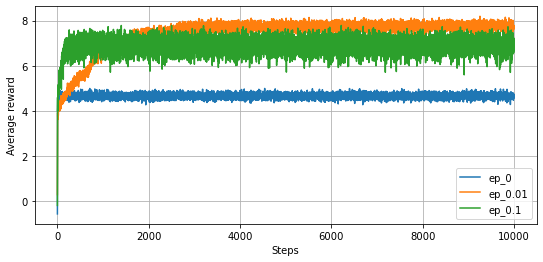

In [4]:
avg_rewards = pd.DataFrame(avg_rewards, columns=['ep_' + str(ep) for ep in epsilons])
avg_rewards.plot(figsize=(9,4))
plt.grid(True)
# plt.xlim((9500, 10000))
plt.ylabel("Average reward")
plt.xlabel("Steps");

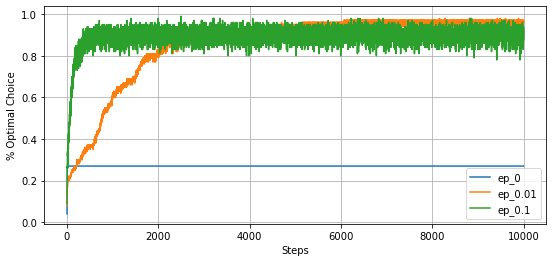

In [5]:
avg_optimal = pd.DataFrame(avg_optimal, columns=['ep_' + str(ep) for ep in epsilons])
avg_optimal.plot(figsize=(9,4))
plt.grid(True)
# plt.xlim((9800, 10000))
plt.ylabel("% Optimal Choice")
plt.xlabel("Steps");

### 2. Demonstration
Non-stationary k-armed bandit problem.

Estimate using sample mean and constant step-size parameter.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def k_bandit_ns_demo(k = 10, steps = 1e4, epsilon = 0.1, q_start = 0, step_fn = lambda x: 1 / x):
    true_means = np.random.normal(size=k, scale = 2)
    Q_estimate = np.ones(k) * q_start
    observations = np.zeros(k)
    rewards = np.zeros(int(steps))        # Float
    optimal_obs = np.zeros(int(steps))    # T / F
    
    for i in range(int(steps)):
        choice = np.argmax(Q_estimate) if np.random.uniform() > epsilon else np.random.choice(k)
        reward = np.random.normal(loc=true_means[choice])
        observations[choice] += 1
        
        # Updates
        Q_estimate[choice] = Q_estimate[choice] + step_fn(observations[choice])*(reward - Q_estimate[choice])
        optimal_obs[i] = np.argmax(true_means) == choice
        rewards[i] = reward
        
        # Non-stationarity
        true_means += np.random.normal(loc=0, scale=0.3, size=k)
        
    return rewards, optimal_obs

In [8]:
runs = 100
steps = 10000
avg_rewards = np.zeros(shape = (steps, 2))
avg_optimal = np.zeros(shape = (steps, 2))

# Sample averages
col = 0
for i in range(1, runs + 1):
    rewards, optimal_choice = k_bandit_ns_demo(steps = steps)
    avg_rewards[:, col] = avg_rewards[:, col] + (1/i) * (rewards - avg_rewards[:, col])
    avg_optimal[:, col] = avg_optimal[:, col] + (1/i) * (optimal_choice - avg_optimal[:, col])
    if i % 10 == 0:
        print(f"Run number:\t{i}", end="\r")
print()

# Constant step-size parameter
col = 1
for i in range(1, runs + 1):
    rewards, optimal_choice = k_bandit_ns_demo(steps = steps, step_fn = lambda x: 0.1)
    avg_rewards[:, col] = avg_rewards[:, col] + (1/i) * (rewards - avg_rewards[:, col])
    avg_optimal[:, col] = avg_optimal[:, col] + (1/i) * (optimal_choice - avg_optimal[:, col])
    if i % 10 == 0:
        print(f"Run number:\t{i}", end="\r")
print()

Run number:	100
Run number:	100


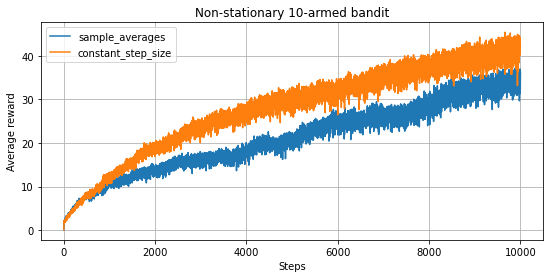

In [9]:
columns = ['sample_averages', 'constant_step_size']
avg_rewards = pd.DataFrame(avg_rewards, columns=columns)
avg_rewards.plot(figsize=(9,4))
plt.grid(True)
plt.ylabel("Average reward")
plt.xlabel("Steps")
plt.title("Non-stationary 10-armed bandit");

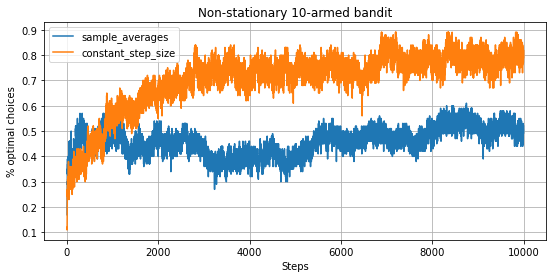

In [10]:
columns = ['sample_averages', 'constant_step_size']
avg_optimal = pd.DataFrame(avg_optimal, columns=columns)
avg_optimal.plot(figsize=(9,4))
plt.grid(True)
plt.ylabel("% optimal choices")
plt.xlabel("Steps")
plt.title("Non-stationary 10-armed bandit");

### Upper-confidence-bound
Use this in conjunction with an epsilon term controlling exploration vs exploitation and only for selecting from the non-greedy actions.

In [ ]:
if observation_counts != 0:
    Q_t + c * np.sqrt(np.log(t) / observation_counts)
else:
    np.which(observation_counts == 0)

## Summary

- $\epsilon$-greedy strategies randomly select an action to perform with probability $\epsilon$. Note that the action performed can happen to be the greedy action too.
- $\epsilon$-greedy strategies with constant $\epsilon$ will never select the best action $100\%$ of the time, even after an infinite amount have allowed it to definitively determine the best action.
- The Sample Mean formula for updating iteratively only works if $Q_0 = 0$ (ensures correctness of $Q_1$). By the law of large numbers, this is guaranteed to converge to the true mean if it is stationary.
- For non-stationary problems we want to give more weight to recent rewards than to long-past rewards. If we use a constant step size to replace the sample mean iterative update formula this produces a weighted average of rewards and our initial estimate of the target ($Q_1$ --> The best estimate we have of the target given all the rewards before $t=1$). This weighted average exponentially decays the weights of past rewards according to $(1-\alpha)$. **Exponential recency-weighted average**
- Convergence conditions - Not every sequence is guaranteed to converge. To converge, the sum of the sequence of step sizes until infinity has to be infinity and the sum of the squares of the step sizes until infinity has to be a finite number. This ensures that the steps are large enough to traverse the whole space and overcome any fluctuations or initial conditions while also ensuring that the steps eventually become smmall enough to assure convergence. While this guarantees convergence it does not determine the presence of bias.
- Initial value estimates can be a form of bias, depending on the calculation performed. If bias is present we can use it to encourage search in the initial execution of an algorithm by using an optimistic bias. This is not too useful for non-stationary problems since the drive for exploration is temporary. Dont give too much weight to the beginning of time since it only happens once. Likewise for sample averaging, it makes no sense to give equal weights to things from long ago.
- Epsilon-greedy strategies select actions indiscriminately with no preference for those that are nearly greedy or particularly uncertain. Consider how close their estimmates are to being optimal and the uncertainty in the estimates. Upper-confidence-bound action selection.

## Exercises

### 2.1
In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is the probability that the greedy action is selected?

P(greedy) = P(greedy, $\epsilon$) + P(greedy, !$\epsilon$) = P(greedy | e) x P(e) + 0.5 = 0.75

### 2.2
k-armed bandit with k=4 actions.

Random actions occured at steps: 4, 5

May have occured: 1, 2, 3

### 2.3
e001 will perform the best since itll eventually find the optimal action and exploit it at a higher rate than e01.

10 actions --> P(optimal | e) = 0.1

Once we know the optimal choice:

P(optimal) = 0.99 + 0.01 x 0.1 = 0.991

Compared to 0.9 + 0.1 x 0.1 = 0.91 for the e = 0.1 option.

### 2.4
Non-constant step sizes:

$Q_{n+1} = Q_n + \alpha_n(a) (R_n - Q_n) = \alpha_n(a) R_n + (1 - \alpha_n(a)) Q_n$


$= \alpha_n(a) R_n + (1 - \alpha_{n}(a))[\alpha_{n-1}(a) R_{n-1} + (1 - \alpha_{n-1}(a))Q_{n-2}]$

Final result:

$ Q_{n+1} = Q_1 \prod_{i=1}^{n} ( 1 - \alpha_i (a)) + \sum_{i=1}^{n} \alpha_i(a) R_i \left(\prod_{j=0}^{n-i-1} ( 1 - \alpha_{n-j})\right)$

###  2.6
Mysterious spikes

The expected number of random tries before the optimal action is selected causes spikes since at that number, most of the runs will then select the optimal action. This is especially so when optimistic initial values are set since both the greedy and non-greedy step effectively choose from the actions randomly.

Accordingly, the osciallations have to do with the distribution of randomly picking the optimal action randomly, from the decreasing set of unpicked options. This distribution is what makes this method perform particularly better or worse, on average, on particular early steps.

### 2.8
UCB spikes

The distinct spike in performance is because for steps 1-10, every action is tried once, so the optimal action is only selected once. On the 11th step the greedy-action is selected, since all actions will have the same uncertainty term and the greedy-action, by definition, offers the highest estimate of the value function. Hence, at step 11, the greedy-action is always chosen and this action is likely to correspond to the true best action.

Subsequent steps then see a decrease because the uncertainty of other actions, that have only been sampled once, relative to the greedy action is large and hence they are likely to be chosen over the greedy action.

### 2.10

E(reward) = 50, behave randomly or consistently pick one action. Doesnt matter.

E(reward) = 55, perform epsilon greedy search first, then shrink epsilon. Eventually, for Case A always choose action 2, and for Case B always choose action 1.